In [1]:
import numpy as np
import brian2 as br
import matplotlib.pyplot as plt
from time import time
from Reservoir.reservoir import Reservoir
import torch
import torchvision.datasets as datasets

INFO       Cache size for target "cython": 1251 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\hi\.cython\brian_extensions" directory. [brian2]


In [2]:
def tr_res(image):
    return np.array(image.resize((10, 10)).getdata()).reshape((1, 10, 10))
params = {'batch_size': 1,
          'shuffle': False}
dat = datasets.MNIST(root='./data', train=True, download=False, transform=tr_res)
dataloader = torch.utils.data.DataLoader(dat, **params)

In [3]:
res = Reservoir(n_neurons_side=10, lbd=2)
res.init_connection_matrix()
res.init_brian()

In [4]:
im, lab = dat[6]
print(lab)

1


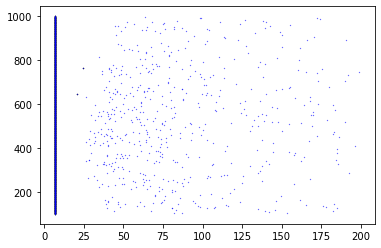

In [4]:
im, lab = dat[0]
res.forward(im/255)
spikes_i = np.concatenate([res.inSpikeMon.i, 100+res.resSpikeMon.i, 900+res.readOutMonitor.i])
spikes_t = np.concatenate([res.inSpikeMon.t/br.ms, res.resSpikeMon.t/br.ms, res.readOutMonitor.t/br.ms])
plt.plot(spikes_t[spikes_t<25], spikes_i[spikes_t<25], '.k', markersize=1) # 
im, lab = dat[6]
res.forward(im/255)
spikes_i = np.concatenate([res.inSpikeMon.i, 100+res.resSpikeMon.i, 900+res.readOutMonitor.i])
spikes_t = np.concatenate([res.inSpikeMon.t/br.ms, res.resSpikeMon.t/br.ms, res.readOutMonitor.t/br.ms])
plt.plot(spikes_t, spikes_i, '.b', markersize=0.5) # [spikes_t<25]

Text(0.5, 0, 'time (ms)')

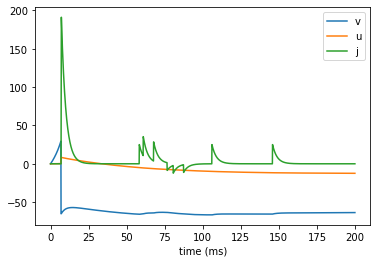

In [5]:
plt.plot(res.stateResMonitor.t/br.ms, res.stateResMonitor.v[0])
plt.plot(res.stateResMonitor.t/br.ms, res.stateResMonitor.u[0])
plt.plot(res.stateResMonitor.t/br.ms, res.stateResMonitor.j[0])

plt.legend(["v","u", "j"])
plt.xlabel("time (ms)")

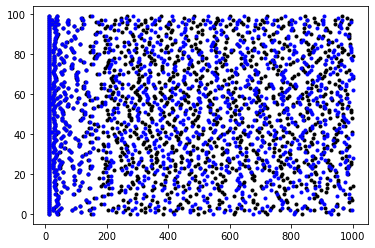

In [15]:
im = np.zeros((10, 10))
S, T = res.forward(im)
plt.plot(T, S, '.k')
im = np.ones((10, 10))
S, T = res.forward(im)
plt.plot(T, S, '.b')

In [11]:
def tr_res(image):
    return np.array(image.resize((10, 10)).getdata()).reshape((1, 10, 10))
params = {'batch_size': 1,
          'shuffle': False}
dat = datasets.MNIST(root='./data', train=True, download=False, transform=tr_res)
dataloader = torch.utils.data.DataLoader(dat, **params)


In [14]:
!pip install tqdm

In [20]:
from tqdm.notebook import tqdm
tbar = tqdm(total=len(dataloader))
for ix, (img, label) in enumerate(dataloader):
    img = img.reshape((10, 10)).numpy()/255.0
    full_emb = res.forward(img)
    np.save(f"embeddings/mnist_{ix}_{label.item()}", full_emb)
    tbar.update(1)


KeyboardInterrupt: 

In [21]:
import os

In [51]:
def get_output_state(T, S, dt=975):
    M = np.zeros((int(S.max()+1), int((1000-15)/5)))
    for time, neuron in zip(T, S):
        if time>15:
            M[int(neuron), int((time-20)//5)] += 1
    return M

In [52]:
embeddings = []
labels = []
for f in os.listdir('embeddings'):
    emb = np.load('embeddings/'+f, 'r')
    embeddings.append(get_output_state(emb[1], emb[0]))
    labels.append(int((f.split('_')[-1])[:-4]))
embeddings = np.array(embeddings)
labels = np.array(labels)

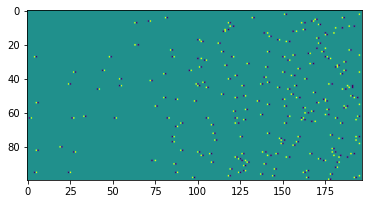

In [78]:
plt.imshow(embeddings[0]-embeddings[6])

In [61]:
cv = 0
mu_l = []
for l in range(10):
    mean = np.mean(embeddings[labels==l], axis=0)
    mu_l.append(mean)
    rho = 0
    for emb in embeddings[labels==l]:
        rho += np.linalg.norm(mean-emb)
    rho /= 10
    cv += rho
cv /= 10
cv = np.mean(rho_l, axis=0)
cd = 0
for mean1 in mu_l:
    for mean2 in mu_l:
        cd += np.linalg.norm(mean1-mean2)
cd /= 100
separation = cd/(cv+1)

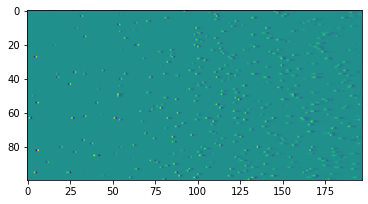

In [88]:
plt.imshow(mu_l[1]-mu_l[8])